In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
from sklearn.inspection import permutation_importance

random_state = 42

In [14]:
def read_dataset(path, sep=';', encoding='utf-8-sig', low_memory=False):
    return pd.read_csv(path, sep=sep, encoding=encoding, low_memory=low_memory)

course_1_bak_spec = read_dataset("../../data/datasets/1st_course_bak_spec.csv")
course_1_magistr = read_dataset("../../data/datasets/1st_course_magistr.csv")

subjects_bak_spec = read_dataset("../../data/datasets/subjects_bak_spec.csv")
subjects_magistr = read_dataset("../../data/datasets/subjects_magistr.csv")

In [15]:
X_c1_bak_spec = course_1_bak_spec.drop(columns=["Таргет"])
y_c1_bak_spec = course_1_bak_spec["Таргет"]

X_train_c1_bak_spec, X_test_c1_bak_spec, y_train_c1_bak_spec, y_test_c1_bak_spec = train_test_split(
    X_c1_bak_spec,
    y_c1_bak_spec,
    test_size=0.2,
    random_state=random_state
)

X_c1_magistr = course_1_magistr.drop(columns=["Таргет"])
y_c1_magistr = course_1_magistr["Таргет"]

X_train_c1_magistr, X_test_c1_magistr, y_train_c1_magistr, y_test_c1_magistr = train_test_split(
    X_c1_magistr,
    y_c1_magistr,
    test_size=0.2,
    random_state=random_state
)

X_s_bak_spec = subjects_bak_spec.drop(columns=["Таргет"])
y_s_bak_spec = subjects_bak_spec["Таргет"]

X_train_s_bak_spec, X_test_s_bak_spec, y_train_s_bak_spec, y_test_s_bak_spec = train_test_split(
    X_s_bak_spec,
    y_s_bak_spec,
    test_size=0.2,
    random_state=random_state
)

X_s_magistr = subjects_magistr.drop(columns=["Таргет"])
y_s_magistr = subjects_magistr["Таргет"]

X_train_s_magistr, X_test_s_magistr, y_train_s_magistr, y_test_s_magistr = train_test_split(
    X_s_magistr,
    y_s_magistr,
    test_size=0.2,
    random_state=random_state
)

Лучшие параметры: {'clf__class_weight': 'balanced', 'clf__l2_regularization': 0.5, 'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__max_iter': 50, 'clf__min_samples_leaf': 10, 'clf__scoring': 'f1'}
Лучшая модель: Pipeline(steps=[('clf',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                early_stopping=True,
                                                l2_regularization=0.5,
                                                learning_rate=0.01, max_depth=3,
                                                max_iter=50,
                                                min_samples_leaf=10,
                                                random_state=42,
                                                scoring='f1'))])

Отчёт классификации:
               precision    recall  f1-score   support

           0       0.99      0.73      0.84       117
           1       0.33      0.94      0.49        17

    accuracy    

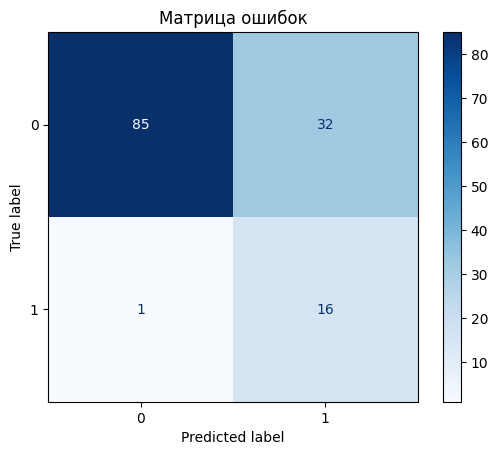


Feature Importances:
                                            feature  importance
37                      Позиция студента в рейтинге    0.299860
8                         Общее количество пересдач    0.001492
7                  Полных лет на момент поступления    0.001422
9                           Общее количество долгов    0.001400
0                                         Приоритет    0.000000
1                            Cумма баллов испытаний    0.000000
5                      Иностранный абитуриент (МОН)    0.000000
4                             Нуждается в общежитии    0.000000
3                                          Контракт    0.000000
2                           Балл за инд. достижения    0.000000
10                                 fromEkaterinburg    0.000000
12                          Human Development Index    0.000000
13                                     Особая квота    0.000000
6                                               Пол    0.000000
18                

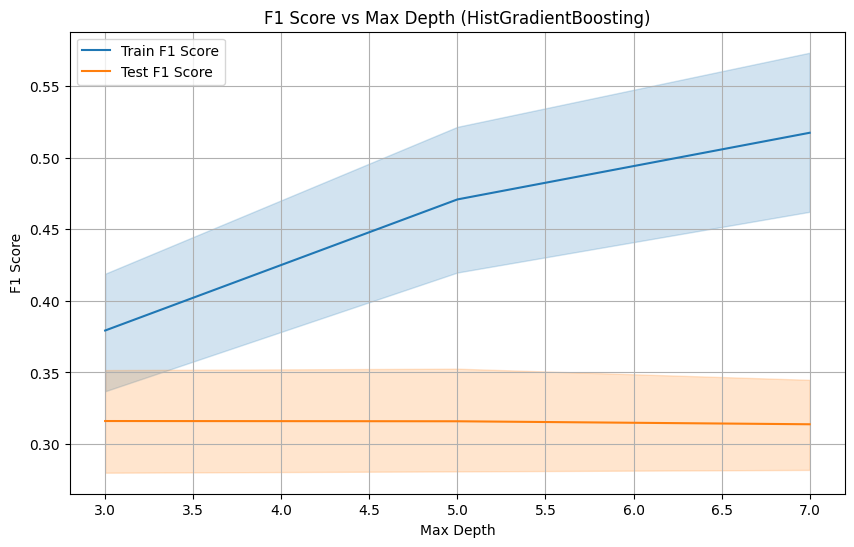

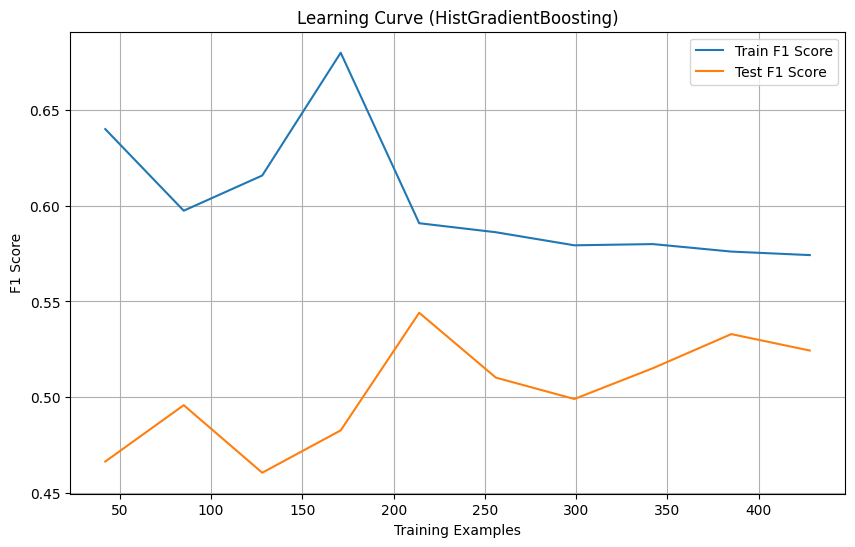

In [16]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import HistGradientBoostingClassifier
import numpy as np
import os

save_dir = 'histgbm/s_magistr'
os.makedirs(save_dir, exist_ok=True)

pipeline = Pipeline([
    ('clf', HistGradientBoostingClassifier(
        random_state=42,
        early_stopping=True
    ))
])

param_grid = {
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__max_iter': [50, 100, 150],
    'clf__max_depth': [3, 5, 7, None],
    'clf__l2_regularization': [0.0, 0.1, 0.5],
    'clf__min_samples_leaf': [1, 5, 10],
    'clf__scoring': ['f1'],
    'clf__class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, return_train_score=True)
grid_search.fit(X_train_s_magistr, y_train_s_magistr)

y_pred = grid_search.predict(X_test_s_magistr)
best_model = grid_search.best_estimator_
joblib.dump(best_model, '../../data/models/histgbm_model_s_magistr.joblib')

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая модель:", best_model)
print("\nОтчёт классификации:\n", classification_report(y_test_s_magistr, y_pred))

cm = confusion_matrix(y_test_s_magistr, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.named_steps['clf'].classes_)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок")
plt.savefig(os.path.join(save_dir, "confusion_matrix_histgbm.png"))
plt.show()

result = permutation_importance(
    best_model,
    X_test_s_magistr,
    y_test_s_magistr,
    scoring='f1',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

importances = result.importances_mean
features = X_train_s_magistr.columns

feature_importances = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

results = pd.DataFrame(grid_search.cv_results_)
results_filtered = results[[
    'param_clf__max_depth',
    'mean_train_score',
    'mean_test_score'
]].copy()
results_filtered['param_clf__max_depth'] = pd.to_numeric(results_filtered['param_clf__max_depth'], errors='coerce')

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_filtered, x='param_clf__max_depth', y='mean_train_score', label='Train F1 Score')
sns.lineplot(data=results_filtered, x='param_clf__max_depth', y='mean_test_score', label='Test F1 Score')
plt.title('F1 Score vs Max Depth (HistGradientBoosting)')
plt.xlabel('Max Depth')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, "f1_vs_max_depth_histgbm.png"))
plt.show()

train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=X_train_s_magistr,
    y=y_train_s_magistr,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='f1',
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Train F1 Score')
plt.plot(train_sizes, test_scores_mean, label='Test F1 Score')
plt.title('Learning Curve (HistGradientBoosting)')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, "learning_curve_histgbm.png"))
plt.show()

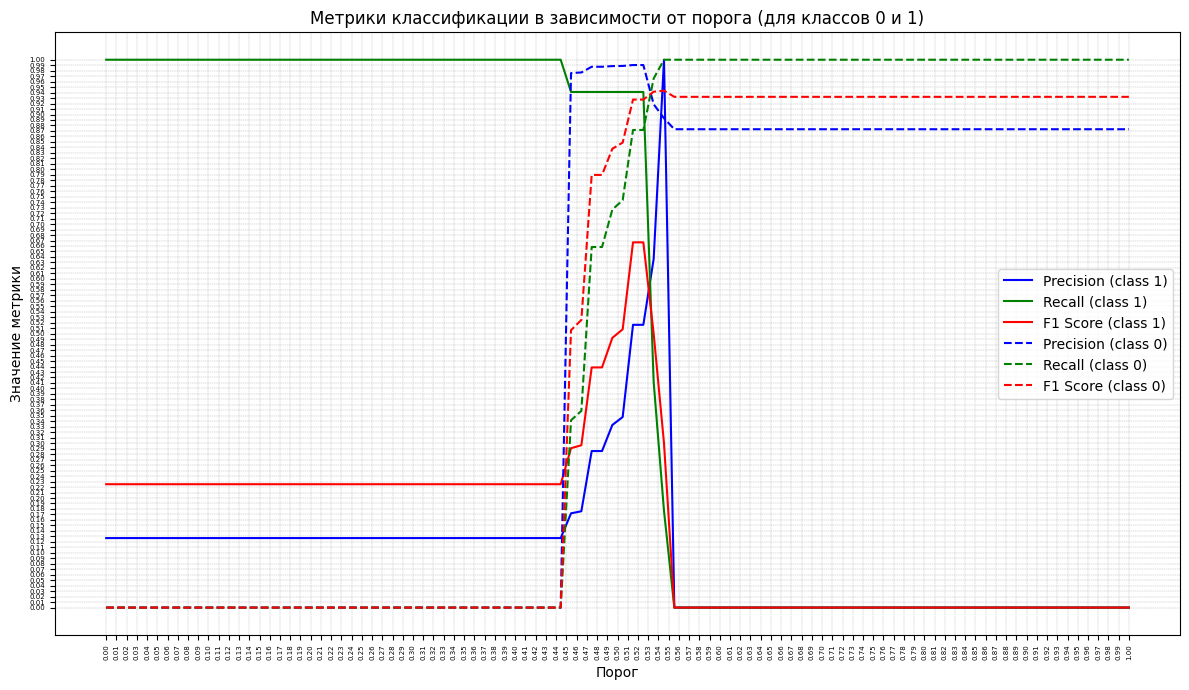

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import os

y_probs = grid_search.predict_proba(X_test_s_magistr)[:, 1]

thresholds = np.linspace(0, 1, 100)

precisions_1, recalls_1, f1_scores_1 = [], [], []
precisions_0, recalls_0, f1_scores_0 = [], [], []

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)

    precisions_1.append(precision_score(y_test_s_magistr, y_pred_thresh, pos_label=1, zero_division=0))
    recalls_1.append(recall_score(y_test_s_magistr, y_pred_thresh, pos_label=1, zero_division=0))
    f1_scores_1.append(f1_score(y_test_s_magistr, y_pred_thresh, pos_label=1, zero_division=0))

    precisions_0.append(precision_score(y_test_s_magistr, y_pred_thresh, pos_label=0, zero_division=0))
    recalls_0.append(recall_score(y_test_s_magistr, y_pred_thresh, pos_label=0, zero_division=0))
    f1_scores_0.append(f1_score(y_test_s_magistr, y_pred_thresh, pos_label=0, zero_division=0))

save_path = 'histgbm/s_magistr'

plt.figure(figsize=(12, 7))

plt.plot(thresholds, precisions_1, label='Precision (class 1)', color='blue')
plt.plot(thresholds, recalls_1, label='Recall (class 1)', color='green')
plt.plot(thresholds, f1_scores_1, label='F1 Score (class 1)', color='red')

plt.plot(thresholds, precisions_0, '--', label='Precision (class 0)', color='blue')
plt.plot(thresholds, recalls_0, '--', label='Recall (class 0)', color='green')
plt.plot(thresholds, f1_scores_0, '--', label='F1 Score (class 0)', color='red')

plt.xticks(np.arange(0, 1.01, 0.01), rotation=90, fontsize=5)
plt.yticks(np.arange(0, 1.01, 0.01), fontsize=5)
plt.grid(True, which='both', linestyle='--', linewidth=0.3)

plt.xlabel('Порог')
plt.ylabel('Значение метрики')
plt.title('Метрики классификации в зависимости от порога (для классов 0 и 1)')
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join(save_path, 'metrics_vs_threshold_histgbm.png'), dpi=300)
plt.show()

Лучшие параметры: {'clf__class_weight': 'balanced', 'clf__l2_regularization': 0.1, 'clf__learning_rate': 0.1, 'clf__max_depth': None, 'clf__max_iter': 50, 'clf__min_samples_leaf': 1, 'clf__scoring': 'f1'}
Лучшая модель: Pipeline(steps=[('clf',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                early_stopping=True,
                                                l2_regularization=0.1,
                                                max_iter=50, min_samples_leaf=1,
                                                random_state=42,
                                                scoring='f1'))])

Отчёт классификации:
               precision    recall  f1-score   support

           0       0.97      0.90      0.94       271
           1       0.63      0.87      0.73        52

    accuracy                           0.90       323
   macro avg       0.80      0.88      0.83       323
weighted avg       0.92      0.90    

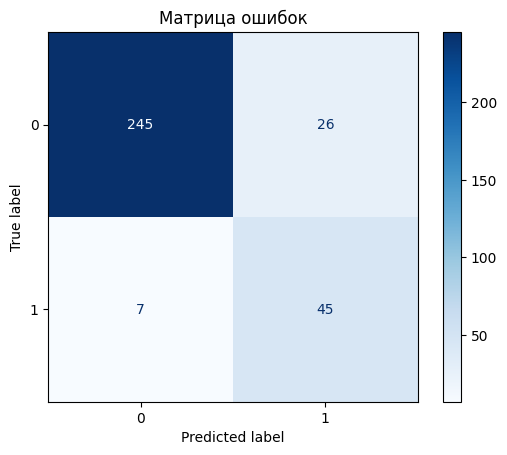


Feature Importances:
                                            feature  importance
10                          Общее количество долгов    0.509234
39                      Позиция студента в рейтинге    0.041988
1                            Cумма баллов испытаний    0.015476
38                             Код направления 3: 4    0.009892
33                            Код направления 1: 11    0.007053
35                            Код направления 1: 29    0.006079
0                                         Приоритет    0.003686
3                           Балл за инд. достижения    0.003541
7                                               Пол    0.003537
36                             Код направления 3: 2    0.001180
15                                  Отдельная квота    0.000590
4                                          Контракт    0.000590
37                             Код направления 3: 3    0.000561
8                  Полных лет на момент поступления    0.000533
2                 

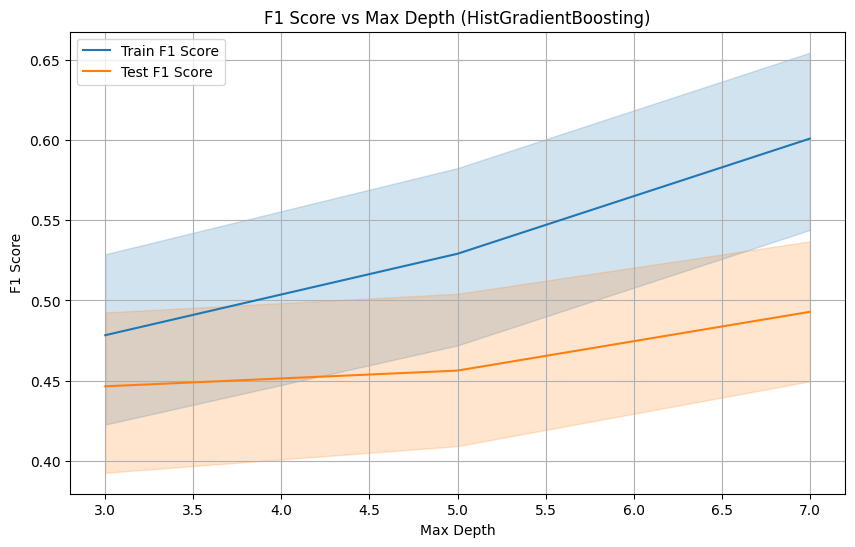

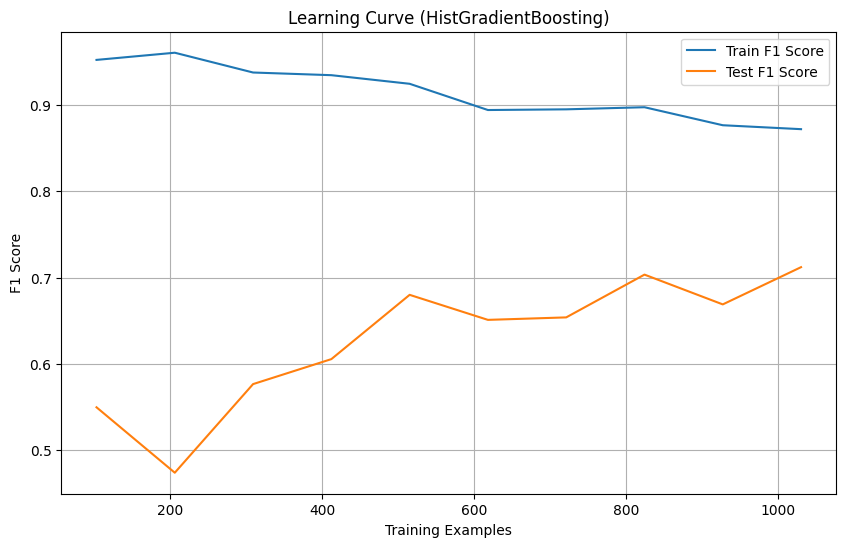

In [18]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import HistGradientBoostingClassifier
import numpy as np
import os

save_dir = 'histgbm/s_bak_spec'
os.makedirs(save_dir, exist_ok=True)

pipeline = Pipeline([
    ('clf', HistGradientBoostingClassifier(
        random_state=42,
        early_stopping=True
    ))
])

param_grid = {
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__max_iter': [50, 100, 150],
    'clf__max_depth': [3, 5, 7, None],
    'clf__l2_regularization': [0.0, 0.1, 0.5],
    'clf__min_samples_leaf': [1, 5, 10],
    'clf__scoring': ['f1'],
    'clf__class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, return_train_score=True)
grid_search.fit(X_train_s_bak_spec, y_train_s_bak_spec)

y_pred = grid_search.predict(X_test_s_bak_spec)
best_model = grid_search.best_estimator_
joblib.dump(best_model, '../../data/models/histgbm_model_s_bak_spec.joblib')

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая модель:", best_model)
print("\nОтчёт классификации:\n", classification_report(y_test_s_bak_spec, y_pred))

cm = confusion_matrix(y_test_s_bak_spec, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.named_steps['clf'].classes_)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок")
plt.savefig(os.path.join(save_dir, "confusion_matrix_histgbm.png"))
plt.show()

result = permutation_importance(
    best_model,
    X_test_s_bak_spec,
    y_test_s_bak_spec,
    scoring='f1',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

importances = result.importances_mean
features = X_train_s_bak_spec.columns

feature_importances = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

results = pd.DataFrame(grid_search.cv_results_)
results_filtered = results[[
    'param_clf__max_depth',
    'mean_train_score',
    'mean_test_score'
]].copy()
results_filtered['param_clf__max_depth'] = pd.to_numeric(results_filtered['param_clf__max_depth'], errors='coerce')

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_filtered, x='param_clf__max_depth', y='mean_train_score', label='Train F1 Score')
sns.lineplot(data=results_filtered, x='param_clf__max_depth', y='mean_test_score', label='Test F1 Score')
plt.title('F1 Score vs Max Depth (HistGradientBoosting)')
plt.xlabel('Max Depth')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, "f1_vs_max_depth_histgbm.png"))
plt.show()

train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=X_train_s_bak_spec,
    y=y_train_s_bak_spec,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='f1',
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Train F1 Score')
plt.plot(train_sizes, test_scores_mean, label='Test F1 Score')
plt.title('Learning Curve (HistGradientBoosting)')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, "learning_curve_histgbm.png"))
plt.show()

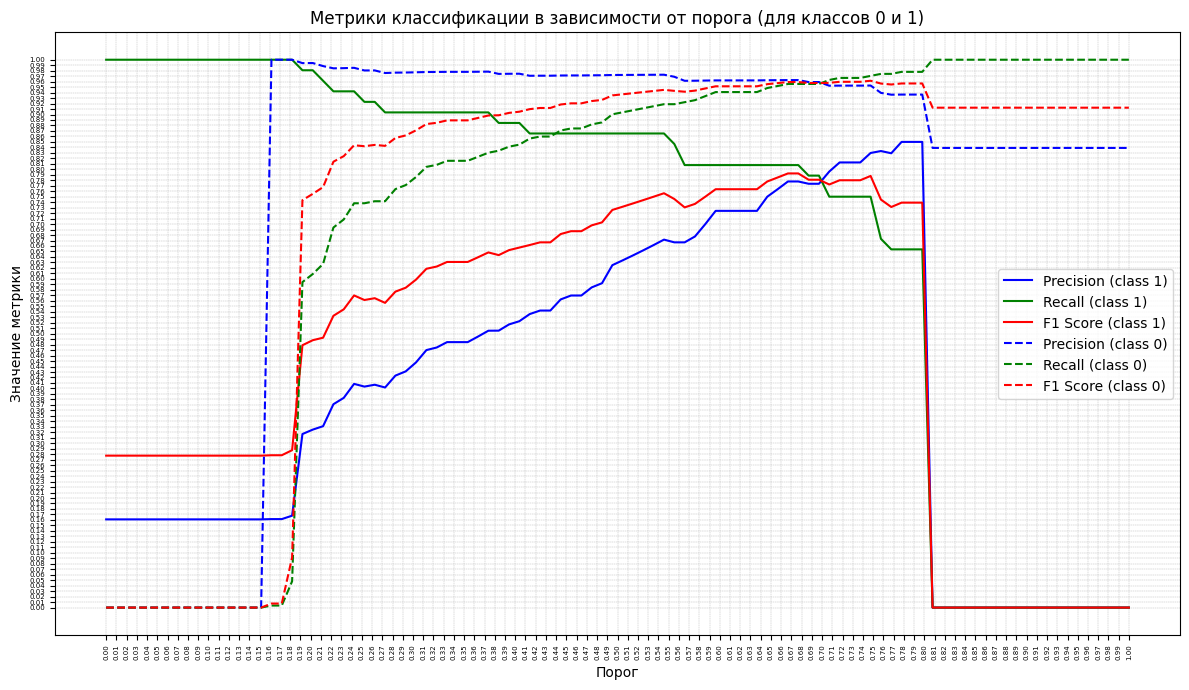

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import os

y_probs = grid_search.predict_proba(X_test_s_bak_spec)[:, 1]

thresholds = np.linspace(0, 1, 100)

precisions_1, recalls_1, f1_scores_1 = [], [], []
precisions_0, recalls_0, f1_scores_0 = [], [], []

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)

    precisions_1.append(precision_score(y_test_s_bak_spec, y_pred_thresh, pos_label=1, zero_division=0))
    recalls_1.append(recall_score(y_test_s_bak_spec, y_pred_thresh, pos_label=1, zero_division=0))
    f1_scores_1.append(f1_score(y_test_s_bak_spec, y_pred_thresh, pos_label=1, zero_division=0))

    precisions_0.append(precision_score(y_test_s_bak_spec, y_pred_thresh, pos_label=0, zero_division=0))
    recalls_0.append(recall_score(y_test_s_bak_spec, y_pred_thresh, pos_label=0, zero_division=0))
    f1_scores_0.append(f1_score(y_test_s_bak_spec, y_pred_thresh, pos_label=0, zero_division=0))

save_path = 'histgbm/s_bak_spec'

plt.figure(figsize=(12, 7))

plt.plot(thresholds, precisions_1, label='Precision (class 1)', color='blue')
plt.plot(thresholds, recalls_1, label='Recall (class 1)', color='green')
plt.plot(thresholds, f1_scores_1, label='F1 Score (class 1)', color='red')

plt.plot(thresholds, precisions_0, '--', label='Precision (class 0)', color='blue')
plt.plot(thresholds, recalls_0, '--', label='Recall (class 0)', color='green')
plt.plot(thresholds, f1_scores_0, '--', label='F1 Score (class 0)', color='red')

plt.xticks(np.arange(0, 1.01, 0.01), rotation=90, fontsize=5)
plt.yticks(np.arange(0, 1.01, 0.01), fontsize=5)
plt.grid(True, which='both', linestyle='--', linewidth=0.3)

plt.xlabel('Порог')
plt.ylabel('Значение метрики')
plt.title('Метрики классификации в зависимости от порога (для классов 0 и 1)')
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join(save_path, 'metrics_vs_threshold_histgbm.png'), dpi=300)
plt.show()

Лучшие параметры: {'clf__class_weight': 'balanced', 'clf__l2_regularization': 0.1, 'clf__learning_rate': 0.01, 'clf__max_depth': 5, 'clf__max_iter': 50, 'clf__min_samples_leaf': 5, 'clf__scoring': 'f1'}
Лучшая модель: Pipeline(steps=[('clf',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                early_stopping=True,
                                                l2_regularization=0.1,
                                                learning_rate=0.01, max_depth=5,
                                                max_iter=50, min_samples_leaf=5,
                                                random_state=42,
                                                scoring='f1'))])

Отчёт классификации:
               precision    recall  f1-score   support

           0       0.86      0.42      0.56       117
           1       0.12      0.53      0.19        17

    accuracy                           0.43       134
   macro avg

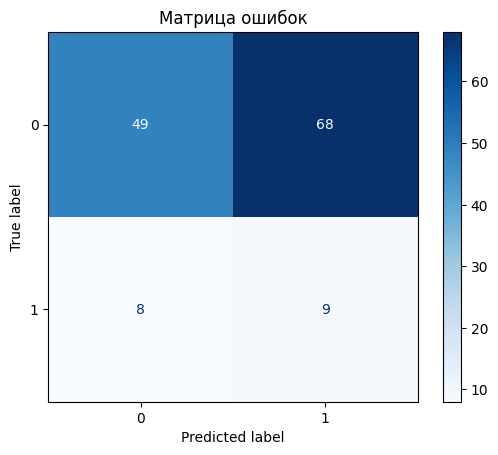


Feature Importances:
                                            feature  importance
8                                  fromEkaterinburg    0.009672
33                             Код направления 3: 3    0.008560
0                                         Приоритет    0.000403
26                                       PostSoviet    0.000000
19                                           Высшее    0.000000
5                      Иностранный абитуриент (МОН)    0.000000
3                                          Контракт    0.000000
6                                               Пол    0.000000
9                              fromSverdlovskRegion    0.000000
10                          Human Development Index    0.000000
4                             Нуждается в общежитии    0.000000
15  олимпиада из перечня, утвержденного МОН РФ (ОШ)    0.000000
12                                  Отдельная квота    0.000000
13                                    Целевая квота    0.000000
14         всеросс

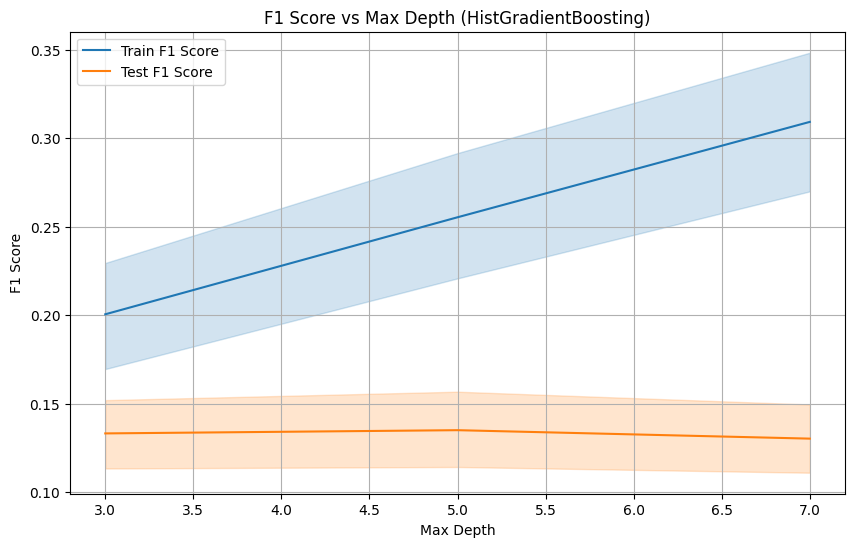

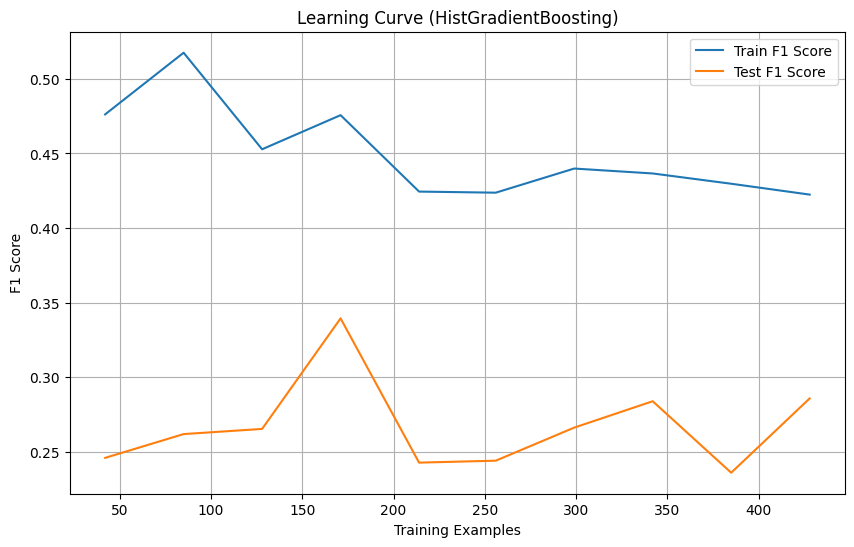

In [20]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import HistGradientBoostingClassifier
import numpy as np
import os

save_dir = 'histgbm/c1_magistr'
os.makedirs(save_dir, exist_ok=True)

pipeline = Pipeline([
    ('clf', HistGradientBoostingClassifier(
        random_state=42,
        early_stopping=True
    ))
])

param_grid = {
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__max_iter': [50, 100, 150],
    'clf__max_depth': [3, 5, 7, None],
    'clf__l2_regularization': [0.0, 0.1, 0.5],
    'clf__min_samples_leaf': [1, 5, 10],
    'clf__scoring': ['f1'],
    'clf__class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, return_train_score=True)
grid_search.fit(X_train_c1_magistr, y_train_c1_magistr)

y_pred = grid_search.predict(X_test_c1_magistr)
best_model = grid_search.best_estimator_
joblib.dump(best_model, '../../data/models/histgbm_model_c1_magistr.joblib')

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая модель:", best_model)
print("\nОтчёт классификации:\n", classification_report(y_test_c1_magistr, y_pred))

cm = confusion_matrix(y_test_c1_magistr, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.named_steps['clf'].classes_)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок")
plt.savefig(os.path.join(save_dir, "confusion_matrix_histgbm.png"))
plt.show()

result = permutation_importance(
    best_model,
    X_test_c1_magistr,
    y_test_c1_magistr,
    scoring='f1',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

importances = result.importances_mean
features = X_train_c1_magistr.columns

feature_importances = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

results = pd.DataFrame(grid_search.cv_results_)
results_filtered = results[[
    'param_clf__max_depth',
    'mean_train_score',
    'mean_test_score'
]].copy()
results_filtered['param_clf__max_depth'] = pd.to_numeric(results_filtered['param_clf__max_depth'], errors='coerce')

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_filtered, x='param_clf__max_depth', y='mean_train_score', label='Train F1 Score')
sns.lineplot(data=results_filtered, x='param_clf__max_depth', y='mean_test_score', label='Test F1 Score')
plt.title('F1 Score vs Max Depth (HistGradientBoosting)')
plt.xlabel('Max Depth')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, "f1_vs_max_depth_histgbm.png"))
plt.show()

train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=X_train_c1_magistr,
    y=y_train_c1_magistr,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='f1',
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Train F1 Score')
plt.plot(train_sizes, test_scores_mean, label='Test F1 Score')
plt.title('Learning Curve (HistGradientBoosting)')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, "learning_curve_histgbm.png"))
plt.show()

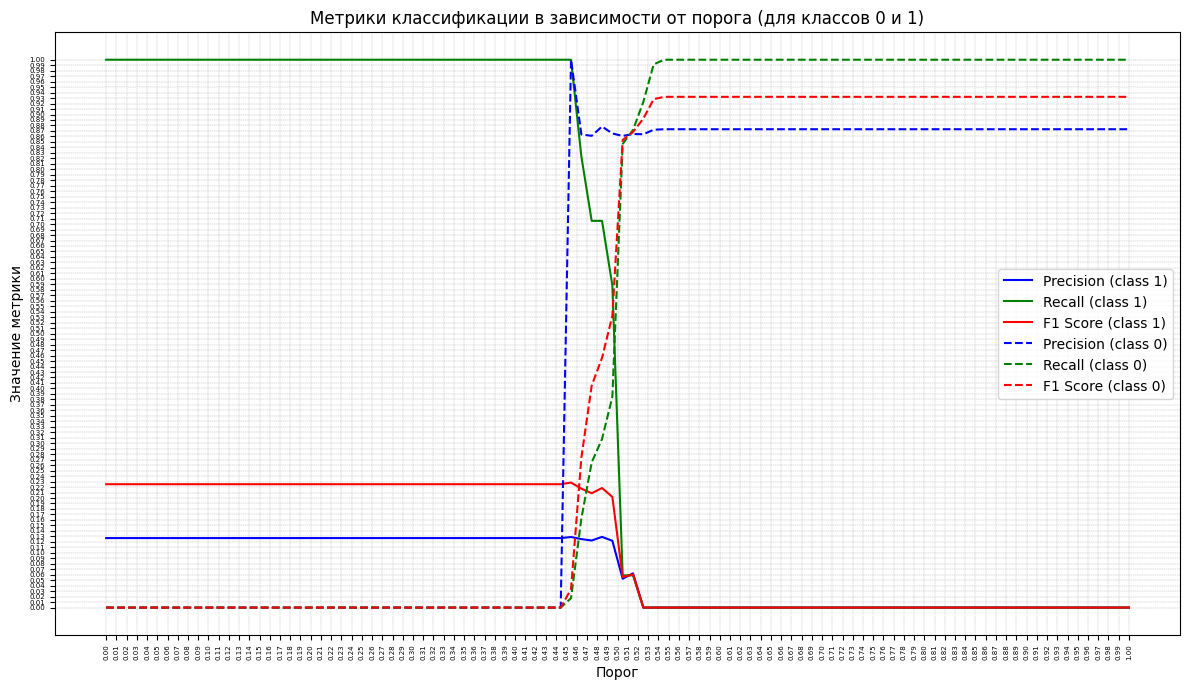

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import os

y_probs = grid_search.predict_proba(X_test_c1_magistr)[:, 1]

thresholds = np.linspace(0, 1, 100)

precisions_1, recalls_1, f1_scores_1 = [], [], []
precisions_0, recalls_0, f1_scores_0 = [], [], []

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)

    precisions_1.append(precision_score(y_test_c1_magistr, y_pred_thresh, pos_label=1, zero_division=0))
    recalls_1.append(recall_score(y_test_c1_magistr, y_pred_thresh, pos_label=1, zero_division=0))
    f1_scores_1.append(f1_score(y_test_c1_magistr, y_pred_thresh, pos_label=1, zero_division=0))

    precisions_0.append(precision_score(y_test_c1_magistr, y_pred_thresh, pos_label=0, zero_division=0))
    recalls_0.append(recall_score(y_test_c1_magistr, y_pred_thresh, pos_label=0, zero_division=0))
    f1_scores_0.append(f1_score(y_test_c1_magistr, y_pred_thresh, pos_label=0, zero_division=0))

save_path = 'histgbm/c1_magistr'

plt.figure(figsize=(12, 7))

plt.plot(thresholds, precisions_1, label='Precision (class 1)', color='blue')
plt.plot(thresholds, recalls_1, label='Recall (class 1)', color='green')
plt.plot(thresholds, f1_scores_1, label='F1 Score (class 1)', color='red')

plt.plot(thresholds, precisions_0, '--', label='Precision (class 0)', color='blue')
plt.plot(thresholds, recalls_0, '--', label='Recall (class 0)', color='green')
plt.plot(thresholds, f1_scores_0, '--', label='F1 Score (class 0)', color='red')

plt.xticks(np.arange(0, 1.01, 0.01), rotation=90, fontsize=5)
plt.yticks(np.arange(0, 1.01, 0.01), fontsize=5)
plt.grid(True, which='both', linestyle='--', linewidth=0.3)

plt.xlabel('Порог')
plt.ylabel('Значение метрики')
plt.title('Метрики классификации в зависимости от порога (для классов 0 и 1)')
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join(save_path, 'metrics_vs_threshold_histgbm.png'), dpi=300)
plt.show()

Лучшие параметры: {'clf__class_weight': 'balanced', 'clf__l2_regularization': 0.0, 'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__max_iter': 50, 'clf__min_samples_leaf': 10, 'clf__scoring': 'f1'}
Лучшая модель: Pipeline(steps=[('clf',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                early_stopping=True,
                                                max_depth=5, max_iter=50,
                                                min_samples_leaf=10,
                                                random_state=42,
                                                scoring='f1'))])

Отчёт классификации:
               precision    recall  f1-score   support

           0       0.93      0.76      0.84       271
           1       0.36      0.69      0.47        52

    accuracy                           0.75       323
   macro avg       0.64      0.73      0.65       323
weighted avg       0.84      0.75      0.78     

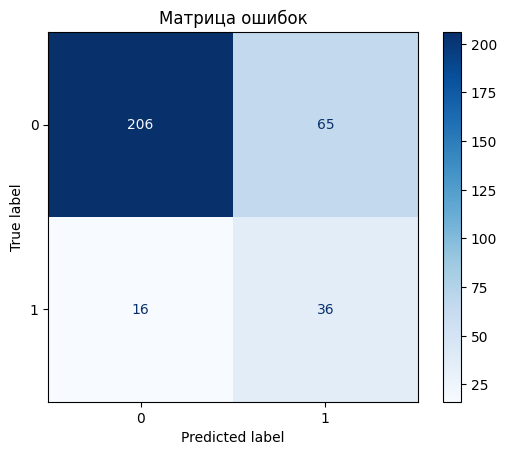


Feature Importances:
                                            feature  importance
8                  Полных лет на момент поступления    0.133657
3                           Балл за инд. достижения    0.061695
1                            Cумма баллов испытаний    0.060559
32                            Код направления 1: 27    0.030011
17                                          Заочная    0.015031
16  олимпиада из перечня, утвержденного МОН РФ (ОШ)    0.014370
19                                       Специалист    0.010277
22                                 Профильная Школа    0.006150
18                                     Очно-заочная    0.003056
21                                           Высшее    0.003056
30                            Код направления 1: 10    0.002929
9                                  fromEkaterinburg    0.002650
31                            Код направления 1: 11    0.002204
11                          Human Development Index    0.001830
14                

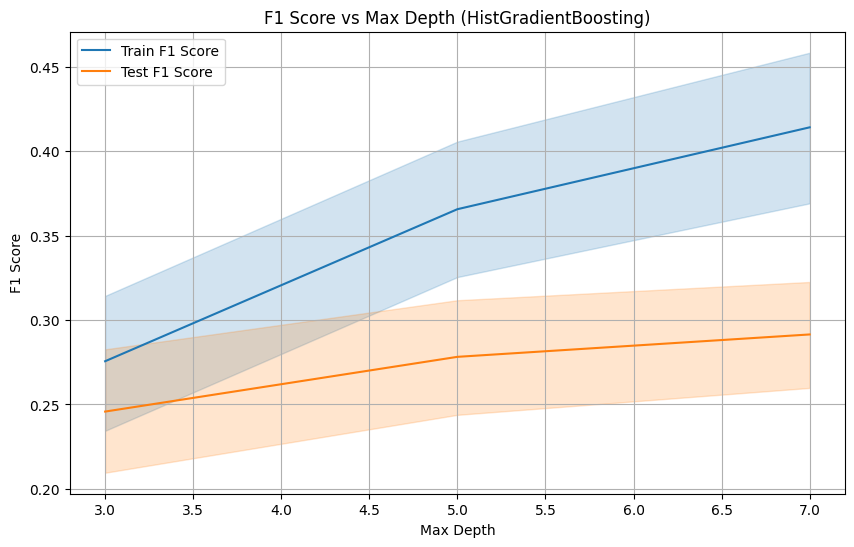

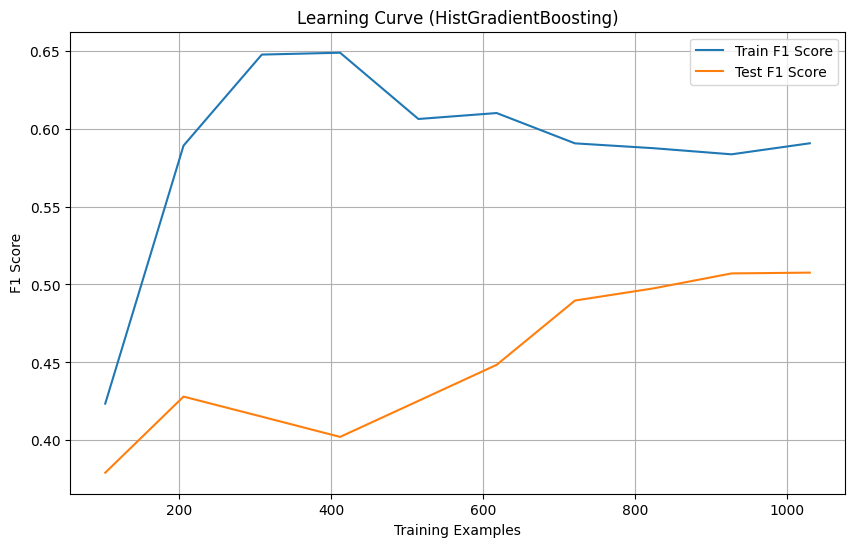

In [22]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import HistGradientBoostingClassifier
import numpy as np
import os

save_dir = 'histgbm/c1_bak_spec'
os.makedirs(save_dir, exist_ok=True)

pipeline = Pipeline([
    ('clf', HistGradientBoostingClassifier(
        random_state=42,
        early_stopping=True
    ))
])

param_grid = {
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__max_iter': [50, 100, 150],
    'clf__max_depth': [3, 5, 7, None],
    'clf__l2_regularization': [0.0, 0.1, 0.5],
    'clf__min_samples_leaf': [1, 5, 10],
    'clf__scoring': ['f1'],
    'clf__class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, return_train_score=True)
grid_search.fit(X_train_c1_bak_spec, y_train_c1_bak_spec)

y_pred = grid_search.predict(X_test_c1_bak_spec)
best_model = grid_search.best_estimator_
joblib.dump(best_model, '../../data/models/histgbm_model_c1_bak_spec.joblib')

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая модель:", best_model)
print("\nОтчёт классификации:\n", classification_report(y_test_c1_bak_spec, y_pred))

cm = confusion_matrix(y_test_c1_bak_spec, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.named_steps['clf'].classes_)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок")
plt.savefig(os.path.join(save_dir, "confusion_matrix_histgbm.png"))
plt.show()

result = permutation_importance(
    best_model,
    X_test_c1_bak_spec,
    y_test_c1_bak_spec,
    scoring='f1',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

importances = result.importances_mean
features = X_train_c1_bak_spec.columns

feature_importances = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

results = pd.DataFrame(grid_search.cv_results_)
results_filtered = results[[
    'param_clf__max_depth',
    'mean_train_score',
    'mean_test_score'
]].copy()
results_filtered['param_clf__max_depth'] = pd.to_numeric(results_filtered['param_clf__max_depth'], errors='coerce')

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_filtered, x='param_clf__max_depth', y='mean_train_score', label='Train F1 Score')
sns.lineplot(data=results_filtered, x='param_clf__max_depth', y='mean_test_score', label='Test F1 Score')
plt.title('F1 Score vs Max Depth (HistGradientBoosting)')
plt.xlabel('Max Depth')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, "f1_vs_max_depth_histgbm.png"))
plt.show()

train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=X_train_c1_bak_spec,
    y=y_train_c1_bak_spec,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='f1',
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Train F1 Score')
plt.plot(train_sizes, test_scores_mean, label='Test F1 Score')
plt.title('Learning Curve (HistGradientBoosting)')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, "learning_curve_histgbm.png"))
plt.show()

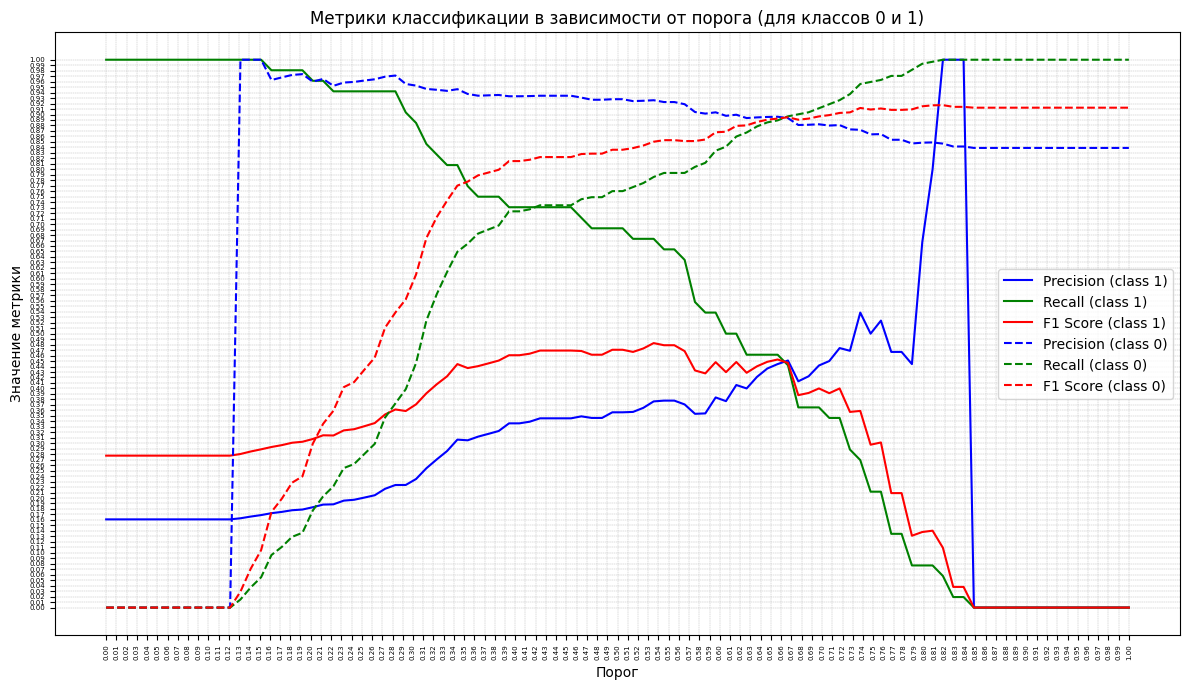

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import os

y_probs = grid_search.predict_proba(X_test_c1_bak_spec)[:, 1]

thresholds = np.linspace(0, 1, 100)

precisions_1, recalls_1, f1_scores_1 = [], [], []
precisions_0, recalls_0, f1_scores_0 = [], [], []

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)

    precisions_1.append(precision_score(y_test_c1_bak_spec, y_pred_thresh, pos_label=1, zero_division=0))
    recalls_1.append(recall_score(y_test_c1_bak_spec, y_pred_thresh, pos_label=1, zero_division=0))
    f1_scores_1.append(f1_score(y_test_c1_bak_spec, y_pred_thresh, pos_label=1, zero_division=0))

    precisions_0.append(precision_score(y_test_c1_bak_spec, y_pred_thresh, pos_label=0, zero_division=0))
    recalls_0.append(recall_score(y_test_c1_bak_spec, y_pred_thresh, pos_label=0, zero_division=0))
    f1_scores_0.append(f1_score(y_test_c1_bak_spec, y_pred_thresh, pos_label=0, zero_division=0))

save_path = 'histgbm/c1_bak_spec'

plt.figure(figsize=(12, 7))

plt.plot(thresholds, precisions_1, label='Precision (class 1)', color='blue')
plt.plot(thresholds, recalls_1, label='Recall (class 1)', color='green')
plt.plot(thresholds, f1_scores_1, label='F1 Score (class 1)', color='red')

plt.plot(thresholds, precisions_0, '--', label='Precision (class 0)', color='blue')
plt.plot(thresholds, recalls_0, '--', label='Recall (class 0)', color='green')
plt.plot(thresholds, f1_scores_0, '--', label='F1 Score (class 0)', color='red')

plt.xticks(np.arange(0, 1.01, 0.01), rotation=90, fontsize=5)
plt.yticks(np.arange(0, 1.01, 0.01), fontsize=5)
plt.grid(True, which='both', linestyle='--', linewidth=0.3)

plt.xlabel('Порог')
plt.ylabel('Значение метрики')
plt.title('Метрики классификации в зависимости от порога (для классов 0 и 1)')
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join(save_path, 'metrics_vs_threshold_histgbm.png'), dpi=300)
plt.show()